In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image
from sklearn.model_selection import train_test_split

from keras.applications import ResNet50
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


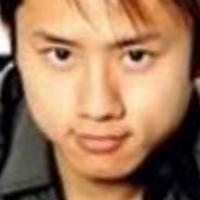

26 0


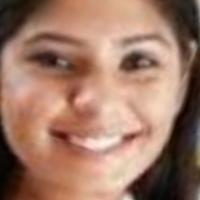

21 1


In [2]:
import os
from PIL import Image
import pandas as pd

images = []
ages = []
genders = []

for i in os.listdir('../input/utkface-new/crop_part1/')[0:8000]:
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    images.append(Image.open('../input/utkface-new/crop_part1/' + i))

images = pd.Series(list(images), name='Images')
ages = pd.Series(list(ages), name='Ages')
genders = pd.Series(list(genders), name='Genders')

df = pd.concat([images, ages, genders], axis=1)
df

display(df['Images'][0])
print(df['Ages'][0], df['Genders'][0])

display(df['Images'][1])
print(df['Ages'][1], df['Genders'][1])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


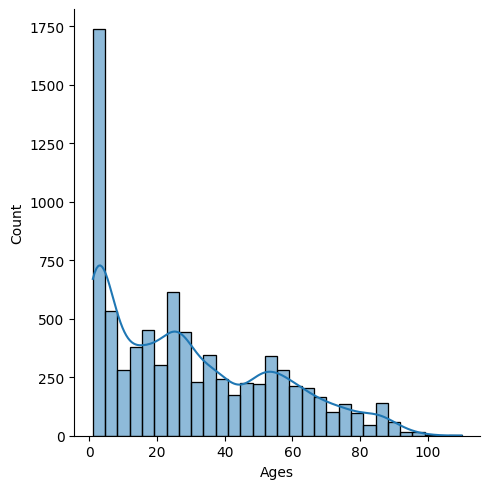

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


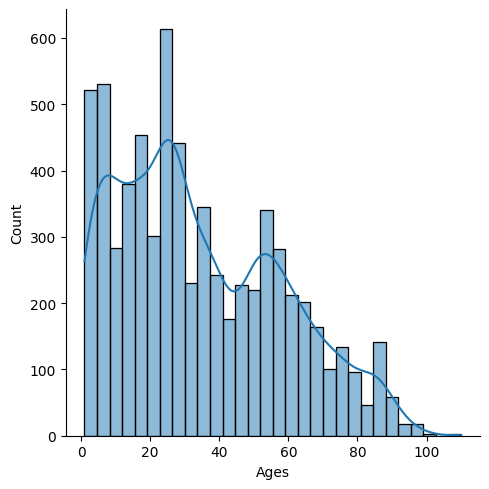

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


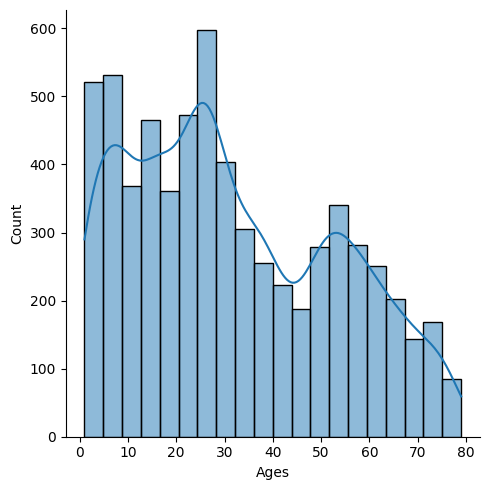

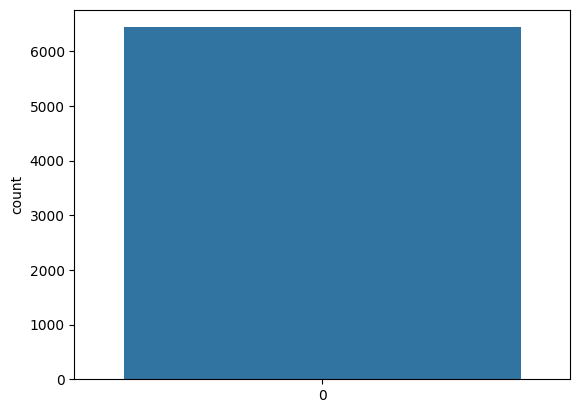

In [3]:
import matplotlib.pyplot as plt


# Plot initial age distribution
sns.displot(df['Ages'], kde=True, bins=30)
plt.show()

# Filter and sample data for ages <= 4
under4s = df[df['Ages'] <= 4].sample(frac=0.3)
df = pd.concat([df[df['Ages'] > 4], under4s], ignore_index=True)

# Plot age distribution after filtering
sns.displot(df['Ages'], kde=True, bins=30)
plt.show()

# Remove ages > 80
df = df[df['Ages'] < 80]

# Plot age distribution after removing ages > 80
sns.displot(df['Ages'], kde=True, bins=20)
plt.show()

# Remove entries with gender = 3
df = df[df['Genders'] != 3]

# Plot gender distribution after filtering gender = 3
sns.countplot(df['Genders'])
plt.show()

# Resize images and prepare data for training
x = []
y = []

for i in range(len(df)):
    resized_image = df['Images'].iloc[i].resize((200, 200), Image.LANCZOS).copy()
    ar = np.asarray(resized_image)
    x.append(ar)
    agegen = [int(df['Ages'].iloc[i]), int(df['Genders'].iloc[i])]
    y.append(agegen)

x = np.array(x)

# Continue with the rest of your code as needed

In [4]:
y_age = df['Ages']
y_gender = df['Genders']

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, stratify=y_age)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, stratify=y_gender)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [5]:
# Creating the Models

# Age Model using ResNet50
age_model = Sequential()
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

age_model.add(resnet_model)
age_model.add(GlobalAveragePooling2D())
age_model.add(Dense(64, activation='relu'))
age_model.add(Dropout(0.5))
age_model.add(Dense(1, activation='linear'))  # Linear activation for regression

age_model.compile(loss='mean_squared_error',
                  optimizer=optimizers.Adam(lr=0.0001),metrics=['accuracy'])

# Gender Model using ResNet50
gender_model = Sequential()
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

gender_model.add(resnet_model)
gender_model.add(GlobalAveragePooling2D())
gender_model.add(Dense(64, activation='relu'))
gender_model.add(Dropout(0.5))
gender_model.add(Dense(1, activation='sigmoid'))

gender_model.compile(loss='binary_crossentropy',
                     optimizer=optimizers.Adam(lr=0.0001),
                     metrics=['accuracy'])

94765736/94765736 [==============================] - 0s 0us/step


In [6]:
# Age Model Training
datagen_age = ImageDataGenerator(
    rescale=1./255., width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

test_datagen_age = ImageDataGenerator(rescale=1./255)

train_age = datagen_age.flow(x_train_age, y_train_age, batch_size=32)
test_age = test_datagen_age.flow(x_test_age, y_test_age, batch_size=32)

history_age = age_model.fit(train_age, epochs=50, shuffle=True, validation_data=test_age)

# Gender Model Training
datagen_gender = ImageDataGenerator(
    rescale=1./255., width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

test_datagen_gender = ImageDataGenerator(rescale=1./255)

train_gender = datagen_gender.flow(x_train_gender, y_train_gender, batch_size=64)
test_gender = test_datagen_gender.flow(x_test_gender, y_test_gender, batch_size=64)

history_gender = gender_model.fit(train_gender, epochs=50, shuffle=True, validation_data=test_gender)

# Print the training history
print("Age Model Training History:")
print("Training Loss:", history_age.history['loss'])
print("Validation Loss:", history_age.history['val_loss'])
print("Training Accuracy:", history_age.history['accuracy'])
print("Validation Accuracy:", history_age.history['val_accuracy'])

print("\nGender Model Training History:")
print("Training Loss:", history_gender.history['loss'])
print("Validation Loss:", history_gender.history['val_loss'])
print("Training Accuracy:", history_gender.history['accuracy'])
print("Validation Accuracy:", history_gender.history['val_accuracy'])

Epoch 1/50
161/161 [==============================] - 87s 271ms/step - loss: 292.1964 - accuracy: 0.0425 - val_loss: 1446.6714 - val_accuracy: 0.0000e+00
Epoch 2/50
161/161 [==============================] - 43s 266ms/step - loss: 192.9095 - accuracy: 0.0421 - val_loss: 1117.3496 - val_accuracy: 0.0427
Epoch 3/50
161/161 [==============================] - 43s 263ms/step - loss: 176.0891 - accuracy: 0.0421 - val_loss: 1364.5931 - val_accuracy: 0.0427
Epoch 4/50
161/161 [==============================] - 44s 270ms/step - loss: 157.5859 - accuracy: 0.0417 - val_loss: 401.8174 - val_accuracy: 0.0427
Epoch 5/50
161/161 [==============================] - 42s 263ms/step - loss: 158.6951 - accuracy: 0.0411 - val_loss: 499.0730 - val_accuracy: 0.0411
Epoch 6/50
161/161 [==============================] - 43s 267ms/step - loss: 142.4802 - accuracy: 0.0425 - val_loss: 474.7457 - val_accuracy: 0.0427
Epoch 7/50
161/161 [==============================] - 43s 268ms/step - loss: 143.0654 - accuracy: 0

In [7]:
# Retrieve final accuracy values for Age Model
final_training_accuracy_age = history_age.history.get('accuracy', history_age.history.get('acc'))
final_validation_accuracy_age = history_age.history.get('val_accuracy', history_age.history.get('val_acc'))

if final_training_accuracy_age is not None:
    final_training_accuracy_age = final_training_accuracy_age[-1] if isinstance(final_training_accuracy_age, list) else final_training_accuracy_age
    print("Age Model Final Training Accuracy:", final_training_accuracy_age)
else:
    print("Age Model Training Accuracy not available.")

if final_validation_accuracy_age is not None:
    final_validation_accuracy_age = final_validation_accuracy_age[-1] if isinstance(final_validation_accuracy_age, list) else final_validation_accuracy_age
    print("Age Model Final Validation Accuracy:", final_validation_accuracy_age)
else:
    print("Age Model Validation Accuracy not available.")

# Retrieve final accuracy values for Gender Model
final_training_accuracy_gender = history_gender.history.get('accuracy', history_gender.history.get('acc'))
final_validation_accuracy_gender = history_gender.history.get('val_accuracy', history_gender.history.get('val_acc'))

if final_training_accuracy_gender is not None:
    final_training_accuracy_gender = final_training_accuracy_gender[-1] if isinstance(final_training_accuracy_gender, list) else final_training_accuracy_gender
    print("Gender Model Final Training Accuracy:", final_training_accuracy_gender)
else:
    print("Gender Model Training Accuracy not available.")

if final_validation_accuracy_gender is not None:
    final_validation_accuracy_gender = final_validation_accuracy_gender[-1] if isinstance(final_validation_accuracy_gender, list) else final_validation_accuracy_gender
    print("Gender Model Final Validation Accuracy:", final_validation_accuracy_gender)
else:
    print("Gender Model Validation Accuracy not available.")

Age Model Final Training Accuracy: 0.04250776395201683
Age Model Final Validation Accuracy: 0.04270186275243759
Gender Model Final Training Accuracy: 0.9683617949485779
Gender Model Final Validation Accuracy: 0.8998447060585022


In [8]:
def process_and_predict(file):
    im = Image.open(file)
    width, height = im.size
    if width == height:
        im = im.resize((200,200), Image.ANTIALIAS)
    else:
        if width > height:
            left = width/2 - height/2
            right = width/2 + height/2
            top = 0
            bottom = height
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.ANTIALIAS)
        else:
            left = 0
            right = width
            top = 0
            bottom = width
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.ANTIALIAS)
            
    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 200, 200, 3)
    
    age = agemodel.predict(ar)
    gender = np.round(genmodel.predict(ar))
    if gender == 0:
        gender = 'male'
    elif gender == 1:
        gender = 'female'
        
    print('Age:', int(age), '\n Gender:', gender)
    return im.resize((300,300), Image.ANTIALIAS)

/tmp/ipykernel_42/3958280607.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((200, 200), Image.ANTIALIAS)


1/1 [==============================] - 1s 1s/step
Age: 16 
 Gender: male
1/1 [==============================] - 0s 22ms/step
Age: 27 
 Gender: male


/tmp/ipykernel_42/3958280607.py:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  return im.resize((300, 300), Image.ANTIALIAS)


1/1 [==============================] - 0s 22ms/step
Age: 40 
 Gender: female
1/1 [==============================] - 0s 25ms/step
Age: 36 
 Gender: female


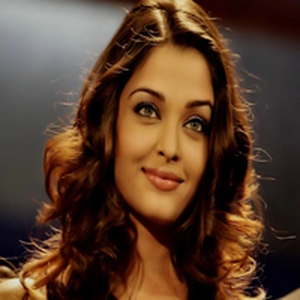

In [9]:
# Process and predict function for ResNet50 models
def process_and_predict_resnet50(file, age_model, gender_model):
    im = Image.open(file)
    im = im.resize((200, 200), Image.ANTIALIAS)
    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 200, 200, 3)

    age = age_model.predict(ar)
    gender = np.round(gender_model.predict(ar))
    if gender == 0:
        gender = 'male'
    elif gender == 1:
        gender = 'female'

    print('Age:', int(age), '\n Gender:', gender)
    return im.resize((300, 300), Image.ANTIALIAS)

# Celebrities prediction with ResNet50 models
process_and_predict_resnet50('../input/celebrity/s1.jpg', age_model, gender_model)
process_and_predict_resnet50('../input/celebrity/s2.jpg', age_model, gender_model)
process_and_predict_resnet50('../input/celebrity/s3.jpg', age_model, gender_model)
process_and_predict_resnet50('../input/celebrity/s4.jpg', age_model, gender_model)

1/1 [==============================] - 0s 23ms/step
Age: 40 
 Gender: female


/tmp/ipykernel_42/3958280607.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((200, 200), Image.ANTIALIAS)
/tmp/ipykernel_42/3958280607.py:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  return im.resize((300, 300), Image.ANTIALIAS)


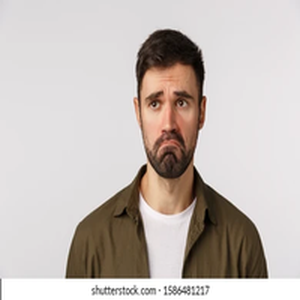

In [10]:
process_and_predict_resnet50('../input/celebrity/s3.jpg', age_model, gender_model)

In [11]:
#Inception v3
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image
from sklearn.model_selection import train_test_split

from keras.applications import InceptionV3
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical



y_age = df['Ages']
y_gender = df['Genders']

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, stratify=y_age)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, stratify=y_gender)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [12]:
# Creating the Models

# Age Model using InceptionV3
age_model_inception = Sequential()
inception_model_age = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

age_model_inception.add(inception_model_age)
age_model_inception.add(GlobalAveragePooling2D())
age_model_inception.add(Dense(64, activation='relu'))
age_model_inception.add(Dropout(0.5))
age_model_inception.add(Dense(1, activation='linear'))  # Linear activation for regression

age_model_inception.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Gender Model using InceptionV3
gender_model_inception = Sequential()
inception_model_gender = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

gender_model_inception.add(inception_model_gender)
gender_model_inception.add(GlobalAveragePooling2D())
gender_model_inception.add(Dense(64, activation='relu'))
gender_model_inception.add(Dropout(0.5))
gender_model_inception.add(Dense(1, activation='sigmoid'))

gender_model_inception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
# Training the Models

# Age Model Training
datagen_age = ImageDataGenerator(
    rescale=1./255., width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

test_datagen_age = ImageDataGenerator(rescale=1./255)

train_age = datagen_age.flow(x_train_age, y_train_age, batch_size=32)
test_age = test_datagen_age.flow(x_test_age, y_test_age, batch_size=32)

history_age_inception = age_model_inception.fit(train_age, epochs=50, shuffle=True, validation_data=test_age)

# Gender Model Training
datagen_gender = ImageDataGenerator(
    rescale=1./255., width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

test_datagen_gender = ImageDataGenerator(rescale=1./255)

train_gender = datagen_gender.flow(x_train_gender, y_train_gender, batch_size=64)
test_gender = test_datagen_gender.flow(x_test_gender, y_test_gender, batch_size=64)

history_gender_inception = gender_model_inception.fit(train_gender, epochs=50, shuffle=True, validation_data=test_gender)



Epoch 1/50
161/161 [==============================] - 78s 266ms/step - loss: 249.6801 - accuracy: 0.0423 - val_loss: 285.5981 - val_accuracy: 0.0427
Epoch 2/50
161/161 [==============================] - 42s 259ms/step - loss: 148.2016 - accuracy: 0.0423 - val_loss: 169.5995 - val_accuracy: 0.0427
Epoch 3/50
161/161 [==============================] - 43s 265ms/step - loss: 124.4484 - accuracy: 0.0423 - val_loss: 85.5562 - val_accuracy: 0.0427
Epoch 4/50
161/161 [==============================] - 42s 259ms/step - loss: 113.1536 - accuracy: 0.0425 - val_loss: 515.1623 - val_accuracy: 0.0202
Epoch 5/50
161/161 [==============================] - 42s 261ms/step - loss: 109.1188 - accuracy: 0.0423 - val_loss: 80.0638 - val_accuracy: 0.0427
Epoch 6/50
161/161 [==============================] - 42s 259ms/step - loss: 100.3887 - accuracy: 0.0425 - val_loss: 134.4229 - val_accuracy: 0.0427
Epoch 7/50
161/161 [==============================] - 42s 259ms/step - loss: 94.1373 - accuracy: 0.0423 - va

In [ ]:
# Evaluate the Age Model on the test dataset
test_loss_age_inception, test_accuracy_age_inception = age_model_inception.evaluate(test_age)
print(f'Test Age Model Accuracy (Inception): {test_accuracy_age_inception * 100:.2f}%')

# Evaluate the Gender Model on the test dataset
test_loss_gender_inception, test_accuracy_gender_inception = gender_model_inception.evaluate(test_gender)
print(f'Test Gender Model Accuracy (Inception): {test_accuracy_gender_inception * 100:.2f}%')

In [ ]:
# Save Age Models
age_model.save('age_model_resnet.h5')
age_model_inception.save('age_model_inception.h5')

# Save Gender Models
gender_model.save('gender_model_resnet.h5')
gender_model_inception.save('gender_model_inception.h5')

In [ ]:
from keras.models import load_model

age_model_resnet = load_model('age_model_resnet.h5')
age_model_inception = load_model('age_model_inception.h5')

gender_model_resnet = load_model('gender_model_resnet.h5')
gender_model_inception = load_model('gender_model_inception.h5')

In [ ]:
from keras.layers import Average

# Ensemble Model for Age
ensemble_age_model = Sequential()
ensemble_age_model.add(Average()([age_model_resnet.output, age_model_inception.output]))
ensemble_age_model.add(Dense(64, activation='relu'))
ensemble_age_model.add(Dropout(0.5))
ensemble_age_model.add(Dense(1, activation='linear'))  # Linear activation for regression

ensemble_age_model.compile(loss='mean_squared_error',
                           optimizer=optimizers.Adam(lr=0.0001),
                           metrics=['accuracy'])

# Ensemble Model for Gender
ensemble_gender_model = Sequential()
ensemble_gender_model.add(Average()([gender_model_resnet.output, gender_model_inception.output]))
ensemble_gender_model.add(Dense(64, activation='relu'))
ensemble_gender_model.add(Dropout(0.5))
ensemble_gender_model.add(Dense(1, activation='sigmoid'))

ensemble_gender_model.compile(loss='binary_crossentropy',
                              optimizer=optimizers.Adam(lr=0.0001),
                              metrics=['accuracy'])

In [ ]:
history_ensemble_age = ensemble_age_model.fit(
    [age_model_resnet.predict(x_train_age), age_model_inception.predict(x_train_age)],
    y_train_age,
    epochs=50,
    shuffle=True,
    validation_data=(
        [age_model_resnet.predict(x_test_age), age_model_inception.predict(x_test_age)],
        y_test_age
    )
)

history_ensemble_gender = ensemble_gender_model.fit(
    [gender_model_resnet.predict(x_train_gender), gender_model_inception.predict(x_train_gender)],
    y_train_gender,
    epochs=50,
    shuffle=True,
    validation_data=(
        [gender_model_resnet.predict(x_test_gender), gender_model_inception.predict(x_test_gender)],
        y_test_gender
    )
)

In [ ]:
test_loss_ensemble_age, test_accuracy_ensemble_age = ensemble_age_model.evaluate(
    [age_model_resnet.predict(x_test_age), age_model_inception.predict(x_test_age)],
    y_test_age
)

test_loss_ensemble_gender, test_accuracy_ensemble_gender = ensemble_gender_model.evaluate(
    [gender_model_resnet.predict(x_test_gender), gender_model_inception.predict(x_test_gender)],
    y_test_gender
)

print(f'Test Ensemble Age Model Accuracy: {test_accuracy_ensemble_age * 100:.2f}%')
print(f'Test Ensemble Gender Model Accuracy: {test_accuracy_ensemble_gender * 100:.2f}%')